In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pymatreader import read_mat

/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
# tf.config.gpu.set_per_process_memory_fraction(0.80)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)])

# tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
print(tf.config.experimental.list_physical_devices('GPU'), tf.executing_eagerly())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] True


In [3]:
# x = [[2.]]
# m = tf.matmul(x, x)
# print("hello, {}".format(m))
# m

### data reading

In [4]:
def extract_labels(mat_bboxes):
    labels = []
    for bbox in mat_bboxes:
        if type(bbox['label']) is list:
            label = ''.join([str(int(value)) for value in bbox['label']])
        else:
            label = str(int(bbox['label']))
        labels.append(label)
    return labels

def convert_to_csv(set_type):
    mat = read_mat(f'data/{set_type}/digitStruct.mat')
    
    df = pd.DataFrame({
        'img_names': mat['digitStruct']['name'], 
        'labels': extract_labels(mat['digitStruct']['bbox'])
    })
    df.to_csv(f'data/{set_type}.csv', index=False)
    return df

In [5]:
# df_train = convert_to_csv('train')
# df_test = convert_to_csv('test')

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

7


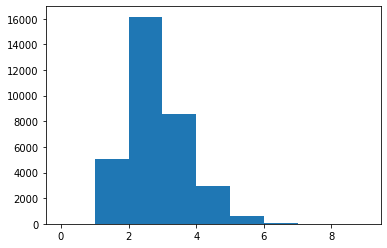

7


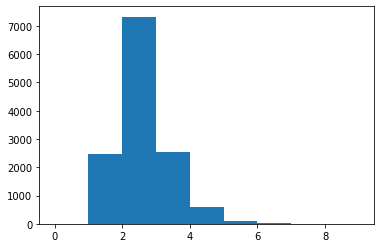

In [7]:
train_lens = df_train['labels'].astype(str).map(lambda s: len(s)).values
plt.hist(train_lens, bins=list(range(10)))
print(train_lens.max())
plt.show()

test_lens = df_test['labels'].astype(str).map(lambda s: len(s)).values
plt.hist(test_lens, bins=list(range(10)))
print(test_lens.max())
plt.show()

In [8]:
MAX_NUMBERS = 4#7
IMAGES_SIZE = 128

In [9]:
df_train.shape, df_test.shape

((33402, 2), (13068, 2))

In [10]:
df_train = df_train[df_train['labels'].astype(str).map(lambda s: len(s)) <= MAX_NUMBERS]
df_test = df_test[df_test['labels'].astype(str).map(lambda s: len(s)) <= MAX_NUMBERS]
df_train.shape, df_test.shape

((32756, 2), (12961, 2))

In [11]:
def encode_label(label, max_numbers=MAX_NUMBERS):
    len_ = len(label)
    len_encoding = np.zeros(max_numbers)
    len_encoding[len_ - 1] = 1
    len_encoding = len_encoding[:, np.newaxis]
    
    numbers_encoding = np.zeros((max_numbers, 10))
    numbers_encoding[np.arange(len_), np.asarray(list(label)).astype(int)] = 1
    return np.hstack((len_encoding, numbers_encoding))

### model

In [12]:
def get_model(max_numbers=MAX_NUMBERS, size=IMAGES_SIZE):
    input_ = x = tf.keras.layers.Input((size, size, 3))
    
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    len_prediction = tf.keras.layers.Dense(128, activation='relu')(x)
    len_prediction = tf.keras.layers.Dense(max_numbers, activation='softmax')(len_prediction)
#     if sparse:
#         len_prediction = tf.keras.backend.argmax(len_prediction, axis=-1) + 1
    len_prediction = tf.keras.backend.expand_dims(len_prediction, axis=-1)
        
    numbers_predictions = []
    for _ in range(max_numbers):
        ni_pred = tf.keras.layers.Dense(128, activation='relu')(x)
        ni_pred = tf.keras.layers.Dense(10, activation='softmax')(ni_pred)
#         if sparse:
#             ni_pred = tf.keras.backend.argmax(ni_pred, axis=-1)
        ni_pred = tf.keras.backend.expand_dims(ni_pred, axis=1)
        numbers_predictions.append(ni_pred)

    output = tf.keras.layers.concatenate([*numbers_predictions], axis=1)
    output = tf.keras.layers.concatenate([len_prediction, output], axis=-1)
    return tf.keras.models.Model(input_, output)

In [13]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
x1 = model.predict(np.random.randint(0, 255, (5, IMAGES_SIZE, IMAGES_SIZE, 3)))
x2 = x1.copy()
x1.shape

(5, 4, 11)

### fitting

In [15]:
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [16]:
# def get_train_X_generator():
#     while True:
#         for img_name in df_train['img_names'].values:
#             img = imread(f'data/train/{img_name}')
#             yield resize(img, (IMAGES_SIZE, IMAGES_SIZE))
                         
# def get_train_Y_generator():
#     while True:
#         for label in df_train['labels'].astype(str).values:
#             yield encode_label(label)
                         
# # train_X = np.asarray([resize(imread(f'data/train/{img_name}'), (IMAGES_SIZE, IMAGES_SIZE)) 
# #                       for img_name in tqdm(df_train['img_names'].values)])
# # train_Y = np.asarray([encode_label(label)
# #                       for label in tqdm(df_train['labels'].astype(str).values)])

# train_X_gen = get_train_X_generator()
# train_Y_gen = get_train_Y_generator()

In [17]:
def get_generator(df, dir_name, batch_size):
    while True:
        images, labels = [], []
        for i, (img_name, label) in enumerate(df[['img_names', 'labels']].values):
            img = imread(f'data/{dir_name}/{img_name}')
            pad_size = max(img.shape[:2])
            pad_img = np.zeros((pad_size, pad_size, 3))
            pad_img[:img.shape[0], :img.shape[1]] = img
            images.append(resize(pad_img, (IMAGES_SIZE, IMAGES_SIZE)))  # devide 255
            labels.append(encode_label(str(label)))
            if ((i + 1) % 16 == 0 and i != 0) or (i + 1) == df.shape[0] - 1:
                yield np.asarray(images), np.asarray(labels)
                images, labels = [], []

In [18]:
gen = get_generator(df_train, 'train', 16)

In [19]:
next(gen)[0].shape

(16, 128, 128, 3)

In [20]:
# class ImagesAccesor:
#     def __init__(self, df):
#         self.images_names = df['img_names'].values

# #     def __next__(self):
# #         for img_name in self.data_frame['img_names'].values:
# #             img = imread(f'data/train/{img_name}')
# #             yield resize(img, (IMAGES_SIZE, IMAGES_SIZE))
    
#     def __getitem__(self, index):
#         print(0)
#         img_name = self.images_names[index]
#         img = imread(f'data/train/{img_name}')
#         return resize(img, (IMAGES_SIZE, IMAGES_SIZE))
    
#     def __len__(self):
#         return self.images_names.shape[0]


# class LabelsAccesor:
#     def __init__(self, df):
#         self.labels = df['labels'].astype(str).values
    
#     def __getitem__(self, index):
#         print(1)
#         return encode_label(self.labels[index])
    
#     def __len__(self):
#         return self.labels.shape[0]

In [21]:
def numbers_loss(y_true, y_pred):
    true_len = y_true[:, :, 0]
    pred_len = y_pred[:, :, 0]
    len_loss = true_len * tf.math.log(pred_len + tf.keras.backend.epsilon())

    true_numbers = y_true[:, :, 1:]
    pred_numbers = y_pred[:, :, 1:]
    numbers_loss = true_numbers * tf.math.log(pred_numbers + tf.keras.backend.epsilon())
    
    return tf.concat((-0.8 * tf.expand_dims(len_loss, axis=-1), 
                      -1.2 * numbers_loss), axis=-1)

In [22]:
def get_len_mask(len_, max_numbers=MAX_NUMBERS):
    return tf.cast(tf.range(MAX_NUMBERS) < len_, tf.int32)

def numbers_acc(y_true, y_pred, weights=[0.3, 0.7]):
    true_len = y_true[:, :, 0]
    pred_len = y_pred[:, :, 0]
    sparse_true_len = tf.argmax(true_len, axis=-1) + 1  # +1 because of length
    len_acc = tf.cast(tf.equal(sparse_true_len, tf.argmax(pred_len, axis=-1) + 1), tf.float32)

    true_numbers = y_true[:, :, 1:]
    pred_numbers = y_pred[:, :, 1:]
    numbers_acc = tf.cast(tf.equal(tf.argmax(true_numbers, axis=-1), 
                                   tf.argmax(pred_numbers, axis=-1)), tf.float32)
    len_mask = tf.map_fn(get_len_mask, tf.cast(sparse_true_len, tf.int32))
    numbers_acc = tf.boolean_mask(numbers_acc, len_mask)
    
    return weights[0] * tf.reduce_mean(len_acc) + weights[1] * tf.reduce_mean(numbers_acc)

In [23]:
numbers_acc(encode_label('211')[np.newaxis, :, :], 
            encode_label('2110')[np.newaxis, :, :])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=910, shape=(), dtype=float32, numpy=0.7>

In [24]:
EPOCHS = 50
BATCH_SIZE = 64
VAL_BATCH_SIZE = 16

# generator = tf.keras.preprocessing.image.ImageDataGenerator(
# #     rescale=1/255,
#     rotation_range=0.05, 
#     zoom_range=0.025,
#     width_shift_range=0.2, 
#     height_shift_range=0.2, 
#     fill_mode="nearest"
# )

model.compile(loss=numbers_loss, optimizer='adam', metrics=[numbers_acc])

model.fit_generator(
#     generator.flow(
#         ImagesAccesor(df_train), LabelsAccesor(df_train), 
#         batch_size=BATCH_SIZE
#     ),
#     validation_split=0.2, 
    get_generator(df_train.iloc[:int(0.8 * df_train.shape[0])], 'train', BATCH_SIZE),
    steps_per_epoch=(0.8 * df_train.shape[0]) // BATCH_SIZE,
    validation_data=get_generator(df_train.iloc[-int(0.2 * df_train.shape[0]):], 'train', VAL_BATCH_SIZE),
    validation_steps=(0.2 * df_train.shape[0]) // VAL_BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/50
409/409 [==============================] - 45s 111ms/step - loss: 0.1582 - numbers_acc: 0.3329 - val_loss: 0.1505 - val_numbers_acc: 0.3325
Epoch 2/50
409/409 [==============================] - 43s 105ms/step - loss: 0.1499 - numbers_acc: 0.3343 - val_loss: 0.1499 - val_numbers_acc: 0.3438
Epoch 3/50
409/409 [==============================] - 42s 104ms/step - loss: 0.1492 - numbers_acc: 0.3432 - val_loss: 0.1496 - val_numbers_acc: 0.3448
Epoch 4/50
409/409 [==============================] - 43s 105ms/step - loss: 0.1495 - numbers_acc: 0.3464 - val_loss: 0.1493 - val_numbers_acc: 0.3452
Epoch 5/50
409/409 [==============================] - 44s 107ms/step - loss: 0.1499 - numbers_acc: 0.3482 - val_loss: 0.1492 - val_numbers_acc: 0.3459
Epoch 6/50
409/409 [==============================] - 43s 105ms/step - loss: 0.1490 - numbers_acc: 0.3411 - val_loss: 0.1495 - val_numbers_acc: 0.3440
Epoch 7/50
409/409 [==============================] - 43s 106ms/step - loss: 0.1485 - numbers_